<a href="https://colab.research.google.com/github/ewyngard/Design-Opt-Project-1/blob/main/Wyngard_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Documentation:

As the popularity of concentrated solar power (CSP) plants grows, it is becoming increasingly important to design systems that can be optimally controlled in order to minimize costs and maintenance of the plant. This becomes apparent with the introduction of thermal energy storage (TES) which allows full-load operations to be sustained even during times with little to no solar radiation (i.e. overcast weather or at night). With this in mind, an objective function has been formulated to “assess the potential of an optimized operation strategy for the considered plant, aimed at maximizing the revenue deriving from the sold electricity. The control objective is an integral cost to be minimized over the integration interval from time tin to tfin” (Casati, 2015). This objective function is given by the following:

tintfin=-WPB*P + c(dudt)2 + gs(u - fminmPB)dt

This formula is subject to a number of constraints which help further define the problem, and guide the optimization process.

WPB=mPB*PB

P = TOD(t)*PPA

u = mPB+s

0 <= s <= u

 WPB represents the power of the power block, which is given by the mass flow rate of the heat transfer fluid (HTF), mPB,  multiplied by the constant power block efficiency, PB. Here, it is important to note that mPB represents the normalized mass flow rate, which is a non-dimensional number that allows for simpler calculations. P is the price of the electricity produced, which is a function of the TOD factors stipulated by the specific tariff multiplied by the PPA, which is the agreed upon bid price of the power purchase agreement. U is the free control variable and it represents the “unconstrained normalized value of the HTF flow to the power block” (Casati, 2015). S is a slack variable which uses an equality constraint as opposed to inequality, while also introducing a non-negativity constraint on s. As for the other variables and constants in the objective function: c is a nonzero constant that is multiplied by the change in u with respect to time in order to “penalize fast oscillations of the control variable, as well as repeated re-starts of the plant during the same day” (Casati, 2015). This helps to avoid infeasible operating conditions. Furthermore, g, which is also nonzero, ensures that the operation of the power block stays above the minimum load. Finally, fmin is the minimum fraction of the mass flow rate to the steam generator.

The objective of this optimization is to find the u and s values which will minimize the objective function, which represents the cost to run the power plant for a designated period of time. By minimizing this cost, the plant is able to maximize its profits. As mentioned by the source paper, if u is larger than fmin, which it is, the term is minimized by using the lowest possible value of s which is 0. In this case, u is equal to m. The results of this analysis reflect this observation nicely.


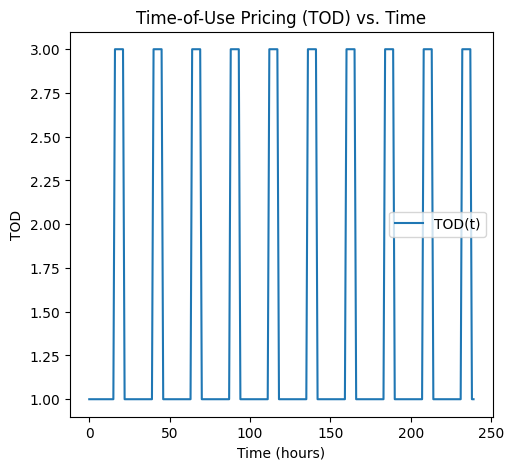

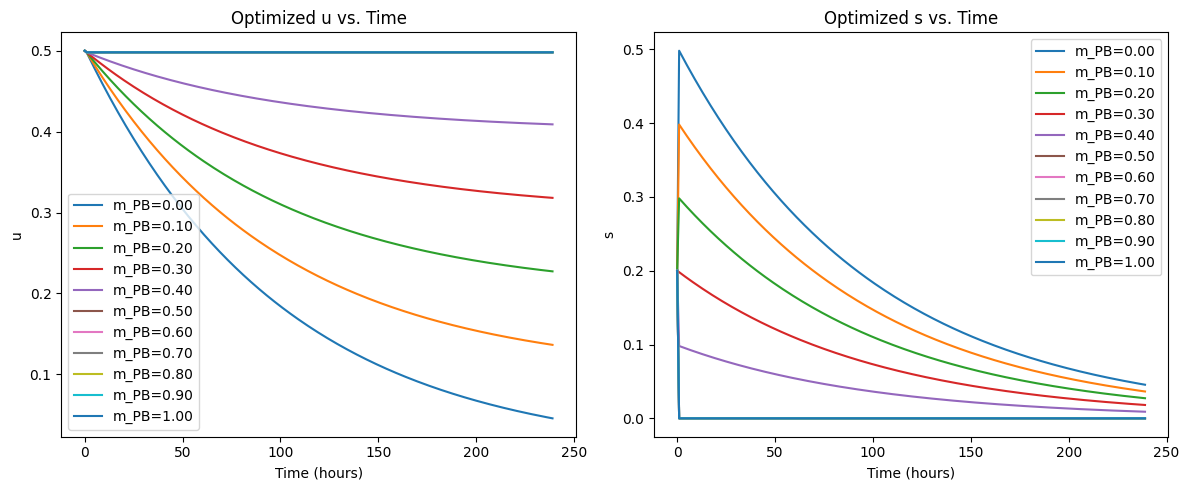

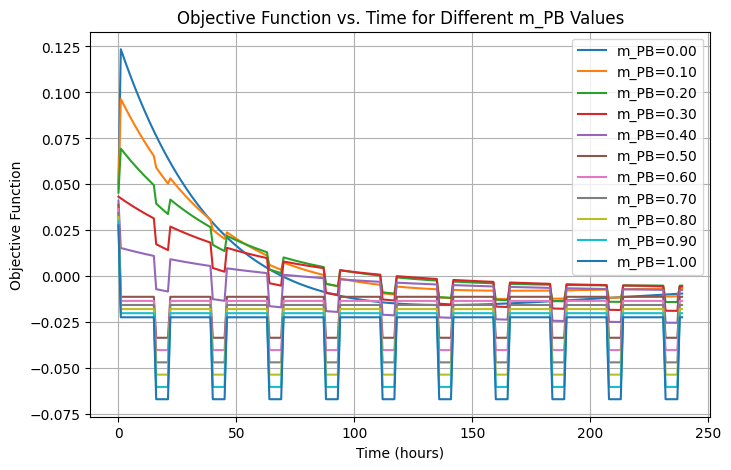

Optimized u: 0.49799999594688416
Optimized s: 0.0


<Figure size 640x480 with 0 Axes>

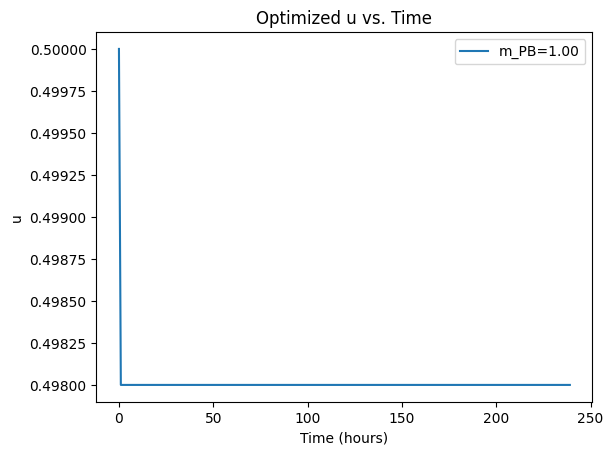

In [26]:
# Third Attempt
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define constants and parameters
n_PB = 0.4  # Efficiency of the power block
c = 2250000 # Coefficient for control variable penalty
g = 1  # Coefficient for slack variable term
t_in = 0  # Initial time
t_fin = 240  # Final time (10 days with 1-hour increments)
initial_u = 0.5  # Initial value for u
initial_s = 0.2  # Initial value for s
f_min = .25  # Minimum fraction of design value (a constant)
PPA = .0557  # Constant bid price of the power purchase agreement

# Define the time-of-day function TOD(t) based on your tariff
def TOD(t):
    # Define peak and off-peak hours
    peak_start = 16  # 4 PM
    peak_end = 21  # 9 PM
    price_peak = 3.0  # 3 times higher during peak hours
    price_off_peak = 1.0  # Base price during off-peak hours

    if peak_start <= t % 24 <= peak_end:
        return price_peak
    else:
        return price_off_peak

# Define time step and number of steps
delta_t = 1  # 1 hour increments
N = int((t_fin - t_in) / delta_t)

# Create a range of m_PB values to try
m_PB_values = torch.linspace(0, 1, 11)  # This will create 11 evenly spaced values from 0 to 1

# Lists to store the optimized values for u and s for each m_PB
optimized_u_values = []
optimized_s_values = []

# Lists to store time series data for u and s
time_series_u = []
time_series_s = []

# Lists to store TOD values for visualization
tod_values = []

# Lists to store the objective function values
objective_values = []

for t in range(N):
    tod_values.append(TOD(t))

# Plot the TOD function
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(N), tod_values, label='TOD(t)')
plt.xlabel('Time (hours)')
plt.ylabel('TOD')
plt.title('Time-of-Use Pricing (TOD) vs. Time')
plt.legend()

plt.plot(1, 2)

for m_PB in m_PB_values:
    # Create tensors for u and s with requires_grad=True
    u = torch.tensor(initial_u, requires_grad=True)
    s = torch.tensor(initial_s, requires_grad=True)

    # Create an optimizer for gradient descent
    optimizer = optim.SGD([u, s], lr=0.01)

    # Initialize U matrix
    u_values = [initial_u]
    s_values = [initial_s]

    objective_function_values = []

    # Initialize total loss
    total_loss = 0

    # Gradient descent optimization loop
    for t in range(N-1):
        optimizer.zero_grad()

        # Compute the price of electricity P(t) based on TOD(t) and PPA
        P = TOD(t) * PPA

        # Define the objective function with W_PB
        W_PB = m_PB * n_PB  # Calculate W_PB using m_PB and n_PB

        # Calculate discrete differences for u and s
        du_dt = (u - u_values[t]) / delta_t

        # Calculate the loss at time t and accumulate with delta_t
        loss = -(W_PB * P) + c * du_dt**2 + g * s * (u - f_min)
        total_loss += loss * delta_t

        loss.backward()
        optimizer.step()

        # Apply constraints to s (range from 0 to u)
        s.data = torch.max(torch.tensor(0.0), u - m_PB)

        u_values.append(u.item())
        s_values.append(s.item())

        # Store the value of the objective function
        objective_function_values.append(loss.item())

    # Ensure the length of objective_values matches the range from 0 to N - 1
    assert len(objective_function_values) == N - 1

    # Append the last value of the objective function for N to align with the x-axis length
    objective_function_values.append(loss.item())

    # The optimized values of u and s are the results for this m_PB
    optimized_u = u.item()
    optimized_s = s.item()

    # Store the optimized values for each m_PB
    optimized_u_values.append(optimized_u)
    optimized_s_values.append(optimized_s)

    # Store time series data for u and s
    time_series_u.append(u_values)
    time_series_s.append(s_values)

    # Store objective function values
    objective_values.append(objective_function_values)

# Plot the results for different m_PB values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, m_PB in enumerate(m_PB_values):
    plt.plot(range(N), time_series_u[i], label=f'm_PB={m_PB:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('u')
plt.title('Optimized u vs. Time')
plt.legend()

plt.subplot(1, 2, 2)
for i, m_PB in enumerate(m_PB_values):
    plt.plot(range(N), time_series_s[i], label=f'm_PB={m_PB:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('s')
plt.title('Optimized s vs. Time')
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

# Plot the objective function for different m_PB values
plt.figure(figsize=(8, 5))
for i, m_PB in enumerate(m_PB_values):
    plt.plot(range(N), objective_values[i], label=f'm_PB={m_PB:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('Objective Function')
plt.title('Objective Function vs. Time for Different m_PB Values')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

print(f"Optimized u: {optimized_u}")
print(f"Optimized s: {optimized_s}")

def update_plot(frame):
    plt.clf()  # Clear the current figure
    plt.plot(range(N), time_series_u[frame], label=f'm_PB={m_PB_values[frame]:.2f}')
    plt.xlabel('Time (hours)')
    plt.ylabel('u')
    plt.title('Optimized u vs. Time')
    plt.legend()


# Create the animation
anim = FuncAnimation(plt.gcf(), update_plot, frames=11, interval=200)
plt.show()

# Save the animation as a GIF or MP4 file
anim.save('animation.gif', writer='pillow')  # For GIF
# anim.save('animation.mp4', writer='ffmpeg')  # For MP4

# Display the animation using HTML
from IPython.display import HTML
# For GIF
HTML('<img src="animation.gif">')
# For MP4
# HTML('<video controls src="animation.mp4">')


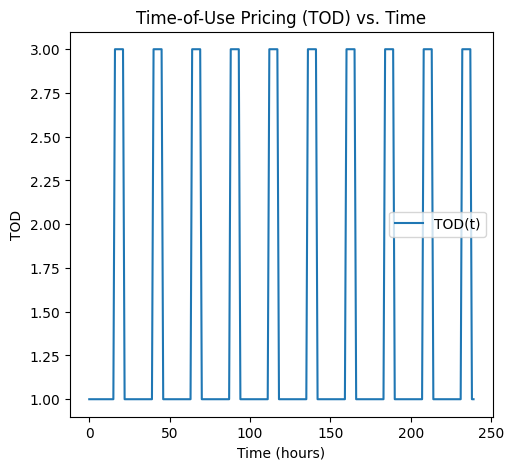

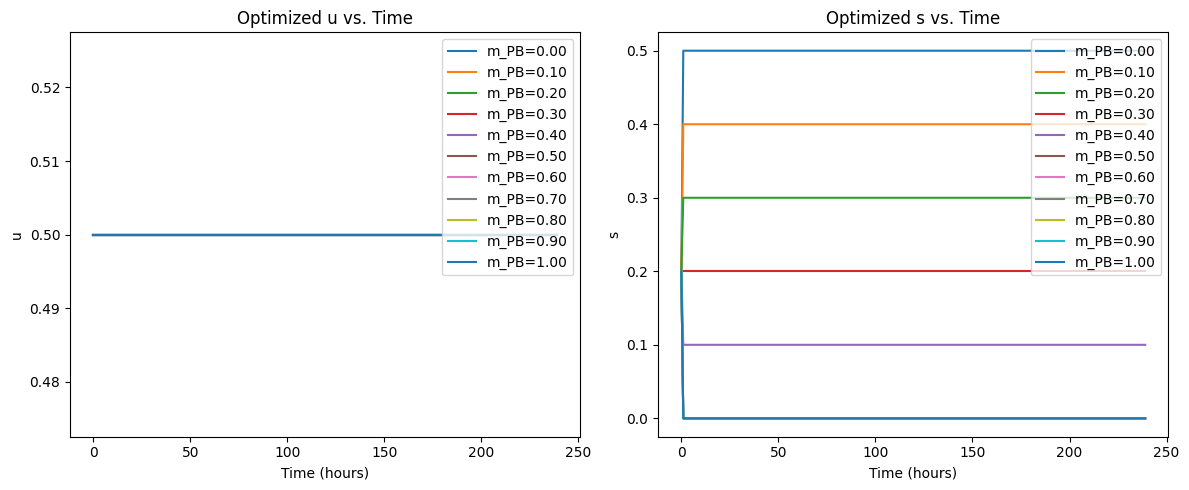

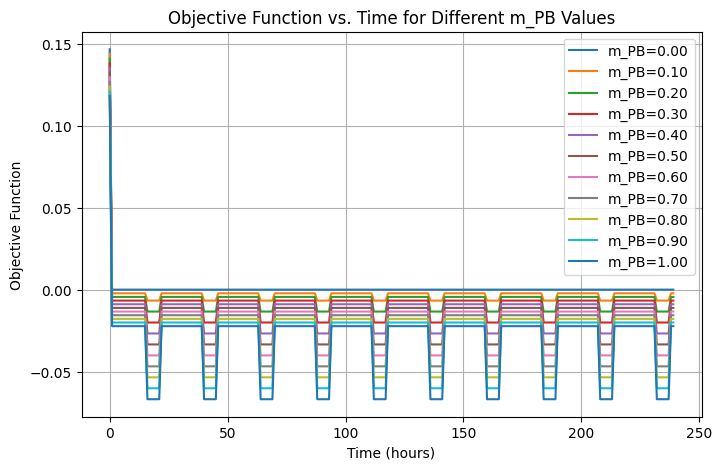

Optimized u: 0.5
Optimized s: 0.0


<Figure size 640x480 with 0 Axes>

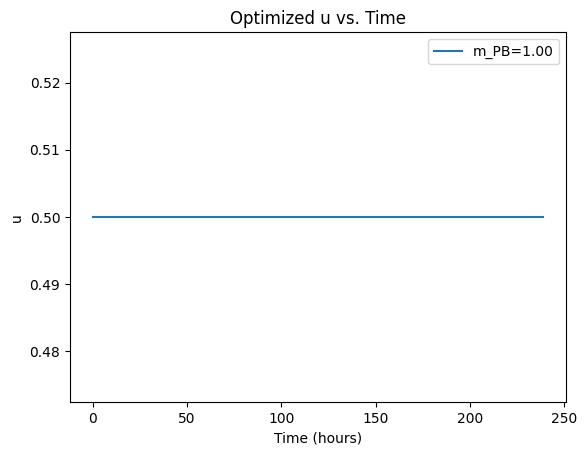

In [25]:
# Fourth attempt using s as a Neural Network

import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn as nn


# Define constants and parameters
n_PB = 0.4  # Efficiency of the power block
c = 2250000 # Coefficient for control variable penalty
g = 1  # Coefficient for slack variable term
t_in = 0  # Initial time
t_fin = 240  # Final time (10 days with 1-hour increments)
initial_u = 0.5  # Initial value for u
initial_s = 0.2  # Initial value for s
f_min = .25  # Minimum fraction of design value (a constant)
PPA = .0557  # Constant bid price of the power purchase agreement

# Define the time-of-day function TOD(t) based on your tariff
def TOD(t):
    # Define peak and off-peak hours
    peak_start = 16  # 4 PM
    peak_end = 21  # 9 PM
    price_peak = 3.0  # 3 times higher during peak hours
    price_off_peak = 1.0  # Base price during off-peak hours

    if peak_start <= t % 24 <= peak_end:
        return price_peak
    else:
        return price_off_peak

# Define time step and number of steps
delta_t = 1  # 1 hour increments
N = int((t_fin - t_in) / delta_t)

# Create a range of m_PB values to try
m_PB_values = torch.linspace(0, 1, 11)  # This will create 11 evenly spaced values from 0 to 1

# Lists to store the optimized values for u and s for each m_PB
optimized_u_values = []
optimized_s_values = []

# Lists to store time series data for u and s
time_series_u = []
time_series_s = []

# Define the neural network class
class SNetwork(nn.Module):
    def __init__(self):
        super(SNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 1)  # Single input, single output for 's'

    def forward(self, x):
        x = self.fc1(x)
        return torch.max(x, torch.zeros_like(x))  # Ensure 's' is non-negative

# Instantiate the neural network
s_nn = SNetwork()

# Define optimizer for the neural network parameters
optimizer_nn = optim.SGD(s_nn.parameters(), lr=0.01)

# Lists to store neural network predicted values for 's'
predicted_s_values = []

# Lists to store TOD values for visualization
tod_values = []

# Lists to store the objective function values
objective_values = []

for t in range(N):
    tod_values.append(TOD(t))

# Plot the TOD function
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(N), tod_values, label='TOD(t)')
plt.xlabel('Time (hours)')
plt.ylabel('TOD')
plt.title('Time-of-Use Pricing (TOD) vs. Time')
plt.legend()

plt.plot(1, 2)

for m_PB in m_PB_values:
    s_nn.train()  # Set the network to training mode

    objective_function_values = []

    # Initialize total loss
    total_loss = 0

    # Initialize u and s for each m_PB iteration
    u = torch.tensor(initial_u, requires_grad=True)
    s = torch.tensor(initial_s, requires_grad=True)

    u_values = [initial_u]
    s_values = [initial_s]

    # Gradient descent optimization loop
    for t in range(N-1):
        optimizer_nn.zero_grad()

        input_time = torch.tensor([[t]], dtype=torch.float32)
        predicted_s = s_nn(input_time)

        # Compute the price of electricity P(t) based on TOD(t) and PPA
        P = TOD(t) * PPA

        # Define the objective function with W_PB
        W_PB = m_PB * n_PB  # Calculate W_PB using m_PB and n_PB

        du_dt = (u - u_values[t]) / delta_t

        # Calculate the loss at time t and accumulate with delta_t
        loss = -(W_PB * P) + c * du_dt**2 + g * predicted_s * (u - f_min)
        total_loss += loss * delta_t

        loss.backward()
        optimizer_nn.step()

        # Apply constraints to s (range from 0 to u)
        s.data = torch.max(torch.tensor(0.0), u - m_PB)

        u_values.append(u.item())
        s_values.append(s.item())

        objective_function_values.append(loss.item())

    # Ensure the length of objective_values matches the range from 0 to N - 1
    assert len(objective_function_values) == N - 1

    # Append the last value of the objective function for N to align with the x-axis length
    objective_function_values.append(loss.item())

    # The optimized values of u and s are the results for this m_PB
    optimized_u = u.item()
    optimized_s = s.item()

    # Store the optimized values for each m_PB
    optimized_u_values.append(optimized_u)
    optimized_s_values.append(optimized_s)

    # Store time series data for u and s
    time_series_u.append(u_values)
    time_series_s.append(s_values)

    # Store objective function values
    objective_values.append(objective_function_values)

# Plot the results for different m_PB values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, m_PB in enumerate(m_PB_values):
    plt.plot(range(N), time_series_u[i], label=f'm_PB={m_PB:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('u')
plt.title('Optimized u vs. Time')
plt.legend()

plt.subplot(1, 2, 2)
for i, m_PB in enumerate(m_PB_values):
    plt.plot(range(N), time_series_s[i], label=f'm_PB={m_PB:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('s')
plt.title('Optimized s vs. Time')
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

# Plot the objective function for different m_PB values
plt.figure(figsize=(8, 5))
for i, m_PB in enumerate(m_PB_values):
    plt.plot(range(N), objective_values[i], label=f'm_PB={m_PB:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('Objective Function')
plt.title('Objective Function vs. Time for Different m_PB Values')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

print(f"Optimized u: {optimized_u}")
print(f"Optimized s: {optimized_s}")

def update_plot(frame):
    plt.clf()  # Clear the current figure
    plt.plot(range(N), time_series_u[frame], label=f'm_PB={m_PB_values[frame]:.2f}')
    plt.xlabel('Time (hours)')
    plt.ylabel('u')
    plt.title('Optimized u vs. Time')
    plt.legend()


# Create the animation
anim = FuncAnimation(plt.gcf(), update_plot, frames=11, interval=200)
plt.show()

# Save the animation as a GIF or MP4 file
# For example, for an animation object named 'anim'
anim.save('animation.gif', writer='pillow')  # For GIF
# anim.save('animation.mp4', writer='ffmpeg')  # For MP4

# Display the animation using HTML
from IPython.display import HTML
# For GIF
HTML('<img src="animation.gif">')
# For MP4
# HTML('<video controls src="animation.mp4">')



Analysis of Results:

This was a nontrivial problem to solve. It took many iterations of the code to finally produce a viable solution and there were many lessons that I learned throughout the entire process. The most glaringly obvious lesson is that the code was never going to be perfect, especially not the first time I tried to implement it. I spent many hours trying to get my first code to work, and realized that I had been approaching the problem wrong the whole time. It was difficult to acknowledge that I would have more success if I tried a completely new approach.

Initially, I had set mPB as a constant, and quickly realized that in order to actually consider all possibilities for optimization that I needed to vary this. I also chose arbitrary values for the TOD schedule in order to obtain the general behavior of a typical TOD schedule where the rates for electricity vary based on the time of day that they are being used. These numbers were sourced from the Pacific Gas & Electric website to get an idea of what real tariff prices look like.


These results were calculated using PyTorch, which I had never used before. Naturally, this meant that I needed to learn the various commands and syntax that PyTorch offers. One of these was torch.optim.SGD which implements stochastic gradient descent optimization. I used this in order to minimize the loss function by adjusting the parameters iteratively in the direction of the negative gradient. I found this to be particularly useful because it can be used for convex and nonconvex problems and later on I learned that it is effective for training neural networks. Tensors were also a new concept for me, but I quickly learned that they are just multidimensional arrays that allow you to do elementwise operations. I also struggled until I educated myself on PyTorch’s automatic differentiation with backpropagation. The example project uses forward passes for the neural network, however I found it useful to use backwards passes in conjunction with SGD for computing the gradients of the loss function. I learned about these operations after my office hours consultation with Dr. Ren. I had initially done my own optimization without the use of a neural network for s, which he quickly pointed out that I needed to implement. After restructuring my code, I found that using a neural network allowed the solution to converge almost instantly compared to my original formulation. The results of this second implementation may be seen above. As seen, the optimal value for u is strictly .5, whereas the initial implementation yielded a u value of .49799. The use of the neural network made the calculation much more precise and faster in comparison to my original algorithm.

In an attempt to animate my results to show the path of the solutions as they progressed through time, I implored the use of google colab, pycharm, and jupyter. I was unsuccessful with all three of these methods, so I created the plots above to help visualize how quickly and to what values my desired variables converged to.



References:
Casati, E., Casella, F., & Colonna, P. (2015a). (rep.). Design of CSP plants with optimally operated thermal storage. Retrieved October 23, 2023, from https://www.sciencedirect.com/science/article/pii/S0038092X15001875

https://www.pge.com/tariffs/electric.shtml
